In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch.nn as nn
from poker_embeddings.poker_utils.hands import card_distance, normalize_hand
from poker_embeddings.poker_utils.constants import DECK_DICT
from poker_embeddings.poker_utils.datasets import CardDataset
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric import loader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from poker_embeddings.poker_utils.model import plot_train_loss
import torch.nn.functional as F


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# class CardDataset(Dataset):
#     def __init__(self, normalize_dist_matrix=True):
#         card_to_id = {j:i for i,j in DECK_DICT.items()}
#         self.data = pd.DataFrame.from_dict(DECK_DICT, orient='index', columns=['card']).reset_index()
#         self.data.rename({"index":'card_id'},axis=1, inplace=True)
#         self.data['card_rank'] = self.data['card_id'] // 4
#         self.data['card_suit'] = self.data['card_id'] % 4

#         self.dist_matrix = np.zeros((52,52), dtype=int)
#         for i in range(52):
#             for j in range(52):
#                 card1 = self.data.iloc[i]['card']
#                 card2 = self.data.iloc[j]['card']
#                 self.dist_matrix[i,j] = card_distance(normalize_hand((card1,card2)))
#         if normalize_dist_matrix:
#             self.dist_matrix = self.dist_matrix / self.dist_matrix.max()
#         self.dist_matrix = torch.tensor(self.dist_matrix, dtype=torch.float32)
#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         row = self.data.iloc[idx]
#         card_id = row['card_id']
#         suit_id = row['card_suit']
#         rank_id = row['card_rank']
#         dist_vec = self.dist_matrix[idx]
#         return {
#             'card': torch.tensor(card_id, dtype=torch.long),
#             'rank': torch.tensor(rank_id, dtype=torch.long),
#             'suit': torch.tensor(suit_id, dtype=torch.long),
#             'dist_vec': dist_vec
#         }



In [6]:
dataset = CardDataset(normalize_dist_matrix=False)
dataloader = DataLoader(dataset, batch_size=52, shuffle=True)

In [7]:
class CardEncoder(nn.Module):
    def __init__(self, rank_dim=2, suit_dim=2, dist_dim=12):
        super().__init__()
        self.rank_embedder = nn.Embedding(53, rank_dim, padding_idx=52)
        self.suit_embedder = nn.Embedding(53, suit_dim, padding_idx=52)
        self.dist_embedder = nn.Embedding(53, dist_dim, padding_idx=52)
        card_dim = rank_dim + suit_dim + dist_dim
        self.emb_proj = nn.Linear(card_dim, card_dim)
        self.rank_head = nn.Linear(card_dim, 13)
        self.suit_head = nn.Linear(card_dim, 4)
        self.dist_head = nn.Linear(card_dim, 52)

    def get_embeddings(self, card_id):
        rank_emb = self.rank_embedder(card_id)
        suit_emb = self.suit_embedder(card_id)
        dist_emb = self.dist_embedder(card_id)
        emb_cat = torch.cat([rank_emb, suit_emb, dist_emb], dim=1)
        return self.emb_proj(emb_cat)

    def forward(self, card_id):
        rank_emb = self.rank_embedder(card_id)
        suit_emb = self.suit_embedder(card_id)
        dist_emb = self.dist_embedder(card_id)

        emb_cat = torch.cat([rank_emb, suit_emb, dist_emb], dim=1)
        card_emb = self.emb_proj(emb_cat)
        rank_pred = self.rank_head(card_emb)
        suit_pred = self.suit_head(card_emb)
        dist_pred = self.dist_head(card_emb)
        return rank_pred, suit_pred, dist_pred


In [8]:
model = CardEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
epochs = 5000
losses = []
dist_alpha = 5
dist_losses = []
accuracies = {
            'pred_rank': [],
            'pred_suit': []
        }
for epoch in range(epochs):
    model.train()
    tot_loss = 0
    tot_dist_loss = 0
    correct = {
        'pred_rank': 0,
        'pred_suit': 0
        }
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        rank_logits, suit_logits, dist_logits = model(batch['card'])

        rank_loss = F.cross_entropy(rank_logits, batch['rank'])
        suit_loss = F.cross_entropy(suit_logits, batch['suit'])
        dist_loss = F.mse_loss(dist_logits, batch['dist_vec'])
        tot_dist_loss += dist_loss.item()
        loss = rank_loss + suit_loss + dist_loss*dist_alpha

        loss.backward()
        optimizer.step()
        tot_loss += loss.item()

        rank_pred = rank_logits.argmax(dim=1)
        correct['pred_rank'] += (rank_pred == batch['rank']).sum().item()
        suit_pred = suit_logits.argmax(dim=1)
        correct['pred_suit'] += (suit_pred == batch['suit']).sum().item()

    losses.append(tot_loss / len(dataloader))
    dist_losses.append(tot_dist_loss / len(dataloader))
    for key, num in correct.items():
        accuracies[key].append(num / 52)



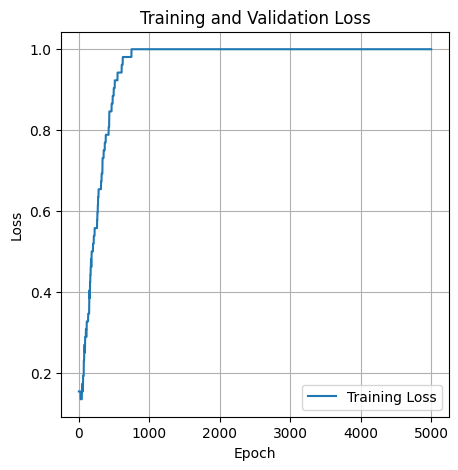

In [10]:
plot_train_loss(accuracies['pred_rank'])

In [11]:
model = model.to('cpu')

In [12]:
model.eval()
with torch.no_grad():
    embeddings = model.get_embeddings(torch.arange(52))
    _, _, dist_pred  = model(torch.arange(52))
    dist_pred = dist_pred.numpy()
    embeddings_np = embeddings.numpy()

In [14]:
classifier = LogisticRegression()
for attr in ['rank','suit']:
    y = dataset.data[f'card_{attr}'].to_numpy()
    classifier.fit(embeddings_np, y=y)
    pred = classifier.predict(embeddings_np)
    acc = accuracy_score(y, pred)
    print(f"{attr} accuracy: {acc}")


rank accuracy: 1.0
suit accuracy: 1.0


In [15]:
embeddings_norm = F.normalize(embeddings)

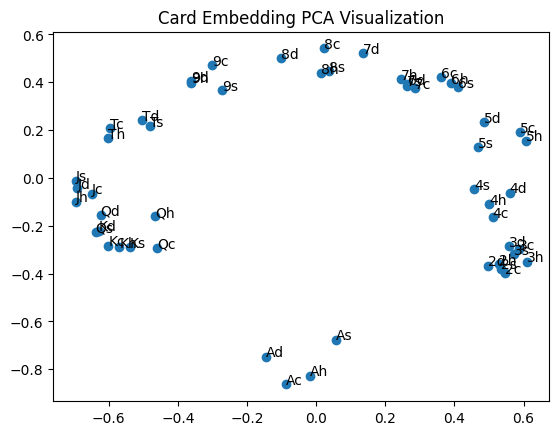

In [16]:

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings_norm.numpy())

plt.scatter(emb_2d[:,0], emb_2d[:,1])
for i, txt in enumerate(dataset.data['card']):
    plt.annotate(txt, (emb_2d[i,0], emb_2d[i,1]))
plt.title("Card Embedding PCA Visualization")
plt.show()

In [24]:
torch.save(embeddings_norm, "../embeddings/card_embeddings.pt")